In [120]:
import numpy as np
from zat.log_to_dataframe import LogToDataFrame 
import zat
import pandas as pd
import matplotlib.pyplot as plt 


In [121]:
# import files etc
dataset_path = "./data/"
log_to_df = LogToDataFrame()
conn_df = log_to_df.create_dataframe(dataset_path + "conn.log")
dns_df = log_to_df.create_dataframe(dataset_path + "dns.log")
http_df = log_to_df.create_dataframe(dataset_path + "http.log")
ssl_df = log_to_df.create_dataframe(dataset_path + "ssl.log")
files_df = log_to_df.create_dataframe(dataset_path + "files.log")

# reset index for all dataframes
conn_df.reset_index(inplace=True)
dns_df.reset_index(inplace=True)
http_df.reset_index(inplace=True)
ssl_df.reset_index(inplace=True)
files_df.reset_index(inplace=True)


/Users/jakubtehlar/Documents/CTU/MGR/stratosphere/work_challenge/files/ML_ch/stratosphere_ml_challenge/.venv/lib/python3.11/site-packages/pandas/core/arrays/timedeltas.py:1163: RuntimeWarning: invalid value encountered in cast
  int_data = data.astype(np.int64)


## EDA
- timestamps
- unique DNS/hosts/IPs/domains
- traffic volume over time
- number of connections per minute
- DNS reqs per minute
- bytes sent/received 
- periodic communication

In [122]:
# explore the conn_df
conn_df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,conn_state,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents
0,2020-09-02 14:33:23.796334982,CMLZbu3FDJYoZwa27k,10.8.0.117,1210,8.8.8.8,53,udp,dns,0 days 00:00:00.010542,31,...,SF,NaN,NaN,0,Dd,1,59,1,108,NaN
1,2020-09-02 14:33:48.334928036,CgRCjV3z8dKmNVIvhb,10.8.0.117,43814,8.8.8.8,53,udp,dns,0 days 00:00:00.010908,33,...,SF,NaN,NaN,0,Dd,1,61,1,115,NaN
2,2020-09-02 14:33:49.757675886,CgFfWv3PUApAZUINNf,10.8.0.117,51631,8.8.8.8,53,udp,dns,0 days 00:00:00.010734,50,...,SF,NaN,NaN,0,Dd,1,78,1,94,NaN
3,2020-09-02 14:33:49.863610983,CIkFu02IznJPZcp1El,10.8.0.117,65449,8.8.8.8,53,udp,dns,0 days 00:00:00.010405,37,...,SF,NaN,NaN,0,Dd,1,65,1,119,NaN
4,2020-09-02 14:33:51.540623903,Cylq6E2mc9lVLjs8ua,10.8.0.117,63247,8.8.8.8,53,udp,dns,0 days 00:00:00.009332,40,...,SF,NaN,NaN,0,Dd,1,68,1,108,NaN


In [123]:
conn_df.describe()

,ts,id.orig_p,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,223,223.0,223.0,190,190.0,190.0,223.0,223.0,223.0,223.0,223.0
mean,2020-09-02 14:48:23.848390656,42422.663677,3103.076233,0 days 00:01:06.408112805,6458.863158,186627.715789,0.0,74.789238,9729.116592,132.03139,168489.753363
min,2020-09-02 14:33:23.796334982,3.0,4.0,0 days 00:00:00.000043,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2020-09-02 14:35:18.751427584,38248.0,53.0,0 days 00:00:00.010982,37.0,64.0,0.0,1.0,65.0,1.0,81.0
50%,2020-09-02 14:38:52.271037184,47812.0,443.0,0 days 00:00:03.003519500,482.0,293.5,0.0,3.0,180.0,1.0,148.0
75%,2020-09-02 15:04:43.380082432,52304.0,5228.0,0 days 00:00:39.887839500,1749.75,3727.0,0.0,15.0,2201.0,13.0,3368.5
max,2020-09-02 15:36:57.062417030,65449.0,57736.0,0 days 00:30:08.665546,692835.0,18081893.0,0.0,6927.0,731444.0,13717.0,18795185.0
std,NaN,16515.438133,8078.990258,0 days 00:02:52.760371969,51082.396905,1401233.614579,0.0,503.116911,56719.860387,986.536878,1352416.032459


In [124]:
conn_df.columns

Index(['ts', 'uid', 'id.orig_h', 'id.orig_p', 'id.resp_h', 'id.resp_p',
       'proto', 'service', 'duration', 'orig_bytes', 'resp_bytes',
       'conn_state', 'local_orig', 'local_resp', 'missed_bytes', 'history',
       'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes',
       'tunnel_parents'],
      dtype='str')

In [125]:
all_dfs = [conn_df, dns_df, http_df, ssl_df, files_df]

for df in all_dfs:
    print(f"Rows: {len(df)}, Columns: {len(df.columns)}, Time range from {df['ts'].min()} to {df['ts'].max()}")

Rows: 223, Columns: 21, Time range from 2020-09-02 14:33:23.796334982 to 2020-09-02 15:36:57.062417030
Rows: 64, Columns: 24, Time range from 2020-09-02 14:33:23.796334982 to 2020-09-02 15:27:20.297641993
Rows: 25, Columns: 30, Time range from 2020-09-02 14:33:23.810384989 to 2020-09-02 15:05:59.264569043
Rows: 78, Columns: 21, Time range from 2020-09-02 14:33:48.338402033 to 2020-09-02 15:27:20.309696913
Rows: 70, Columns: 25, Time range from 2020-09-02 14:33:51.558053017 to 2020-09-02 15:05:59.382664919


In [126]:
# timestamps
start_time = conn_df["ts"].min() 
end_time = conn_df["ts"].max()
print(f"Start time: {start_time}, End time: {end_time}")

Start time: 2020-09-02 14:33:23.796334982, End time: 2020-09-02 15:36:57.062417030


In [127]:
# Unique DNS
dns_df.head()

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,trans_id,rtt,query,...,rcode,rcode_name,AA,TC,RD,RA,Z,answers,TTLs,rejected
0,2020-09-02 14:33:23.796334982,CMLZbu3FDJYoZwa27k,10.8.0.117,1210,8.8.8.8,53,udp,15630,0 days 00:00:00.010542,portal.fb.com,...,0,NOERROR,F,F,T,T,0,"star.c10r.facebook.com,157.240.30.18","174.000000,59.000000",F
1,2020-09-02 14:33:48.334928036,CgRCjV3z8dKmNVIvhb,10.8.0.117,43814,8.8.8.8,53,udp,35052,0 days 00:00:00.010908,i.instagram.com,...,0,NOERROR,F,F,T,T,0,"instagram.c10r.facebook.com,157.240.30.63","3599.000000,2.000000",F
2,2020-09-02 14:33:49.757675886,CgFfWv3PUApAZUINNf,10.8.0.117,51631,8.8.8.8,53,udp,55600,0 days 00:00:00.010734,scontent-prg1-1.cdninstagram.com,...,0,NOERROR,F,F,T,T,0,157.240.30.63,59.000000,F
3,2020-09-02 14:33:49.863610983,CIkFu02IznJPZcp1El,10.8.0.117,65449,8.8.8.8,53,udp,39507,0 days 00:00:00.010405,graph.instagram.com,...,0,NOERROR,F,F,T,T,0,"instagram.c10r.facebook.com,157.240.30.63","3599.000000,30.000000",F
4,2020-09-02 14:33:51.540623903,Cylq6E2mc9lVLjs8ua,10.8.0.117,63247,8.8.8.8,53,udp,41491,0 days 00:00:00.009332,edge-mqtt.facebook.com,...,0,NOERROR,F,F,T,T,0,"mqtt.c10r.facebook.com,157.240.30.11","1236.000000,37.000000",F


In [128]:
# queries
dns_df["query"].unique()

['portal.fb.com', 'i.instagram.com', 'scontent-prg1-1.cdninstagram.com', 'graph.instagram.com', 'edge-mqtt.facebook.com', ..., 'android.clients.google.com', 'mtalk.google.com', 'play.googleapis.com', 'app-measurement.com', 'people-pa.googleapis.com']
Length: 46
Categories (46, str): ['android-safebrowsing.google.com', 'android.clients.google.com', 'android.googleapis.com', 'api-24-0-0.twitter.com', ..., 'video.twimg.com', 'www.facebook.com', 'www.googleapis.com', 'www.msftconnecttest.com']

In [129]:
# DNS servers
dns_df["id.resp_h"].unique()

['8.8.8.8']
Categories (1, str): ['8.8.8.8']

In [130]:
# Client IPs
dns_df["id.orig_h"].unique()

['10.8.0.117']
Categories (1, str): ['10.8.0.117']

Text(0.5, 1.0, 'Number of connections per domain query')

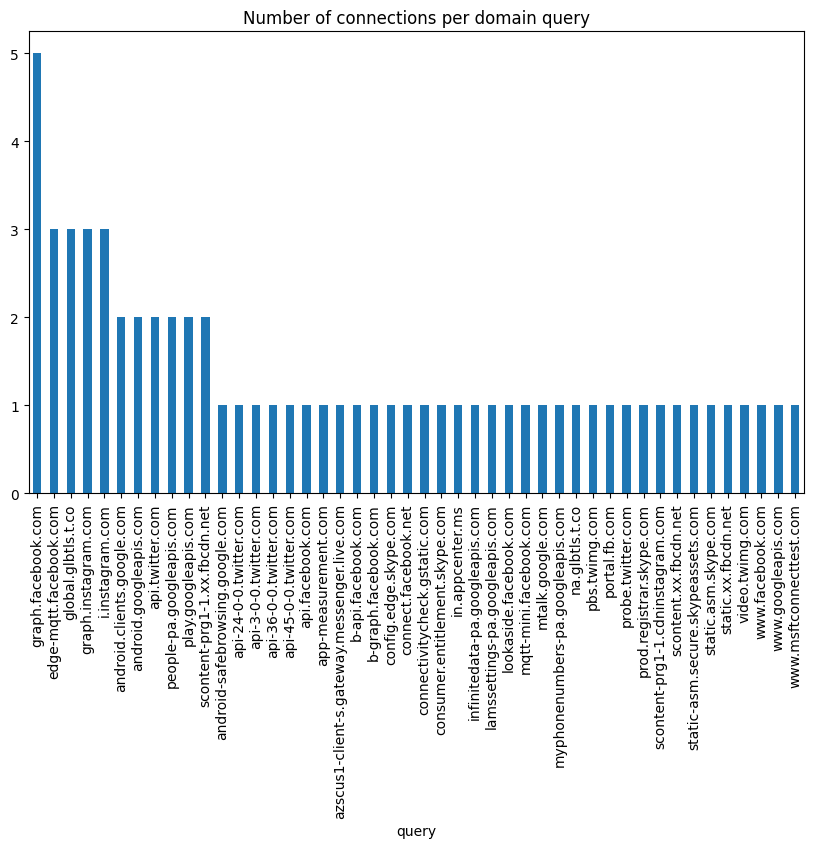

In [131]:
# Plot of connections for each domain query
counts = dns_df["query"].value_counts()

plt.figure(figsize=(10, 6))
counts.plot(kind="bar")
plt.title("Number of connections per domain query")


Text(0.5, 1.0, 'Number of connections per domain')

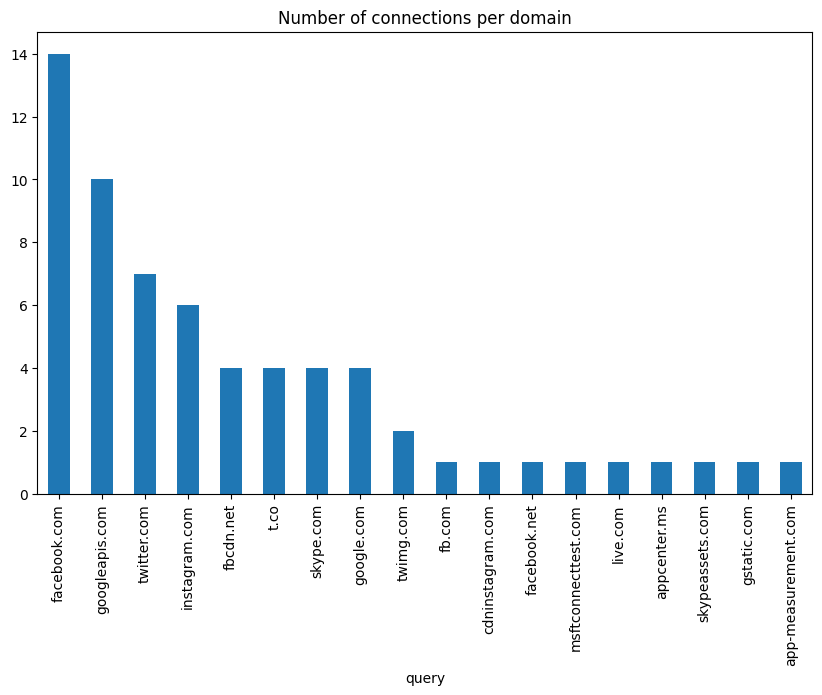

In [132]:
# As can be seen, it there are only few unique domain queries, I will merge all queries of the same domain together
# to have a better understanding of the number of connections per domain 

queries = dns_df["query"]
# x.split(".") - split the query, e.g. -> [www, google, com]
# x.split(".")[-2:] - take the domain name and TLD
# ".".join(...) - join the domain name and TLD back together
domains = queries.apply(lambda x: ".".join((x.split("."))[-2:]))
domains_unique = domains.unique()
counts_ = domains.value_counts()
plt.figure(figsize=(10, 6))
counts_.plot(kind="bar")
plt.title("Number of connections per domain")

In [133]:
# Connections & DNS queries per minute
conns_per_min = conn_df.set_index("ts").resample("1min").size()
conns_per_min


ts
2020-09-02 14:33:00    20
2020-09-02 14:34:00    26
2020-09-02 14:35:00    18
2020-09-02 14:36:00    34
2020-09-02 14:37:00     7
                       ..
2020-09-02 15:32:00     0
2020-09-02 15:33:00     0
2020-09-02 15:34:00     0
2020-09-02 15:35:00     0
2020-09-02 15:36:00     1
Freq: min, Length: 64, dtype: int64

In [134]:
# Connections per minute in the first 4 minutes
conns_per_min[:4]
num_conns_benign = conns_per_min[:4].sum()
print(f"Number of connections in the first 4 minutes: {num_conns_benign}")

# Connections per minute for the rest
num_conns_unknown = conns_per_min[4:].sum()
print(f"Number of connections in the rest: {num_conns_unknown}")


Number of connections in the first 4 minutes: 98
Number of connections in the rest: 125


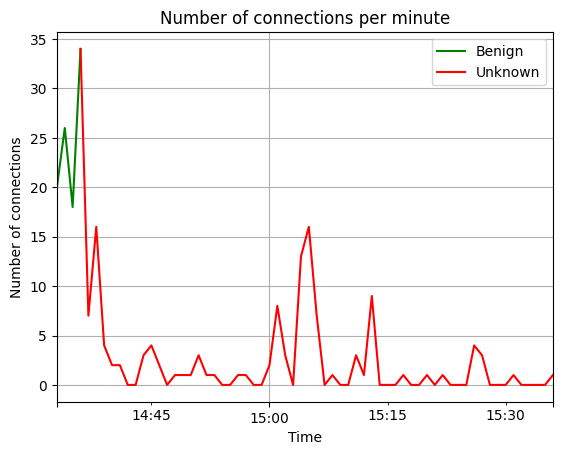

In [135]:
# Plotting connections per minute
conns_per_min[:4].plot(label="Benign", color="green")
conns_per_min[3:].plot(label="Unknown", color="red")
plt.title("Number of connections per minute")
plt.xlabel("Time")
plt.ylabel("Number of connections")
plt.legend()
plt.grid()
plt.show()


In [136]:
# DNS queries per minute
dns_per_min = dns_df.set_index("ts").resample("1min").size()

# DNS queries per minute in the first 4 minutes
num_dns_benign = dns_per_min[:4].sum()
print(f"Number of DNS queries in the first 4 minutes: {num_dns_benign}")

# DNS queries per minute for the rest
num_dns_unknown = dns_per_min[4:].sum()
print(f"Number of DNS queries in the rest: {num_dns_unknown}")

Number of DNS queries in the first 4 minutes: 41
Number of DNS queries in the rest: 23


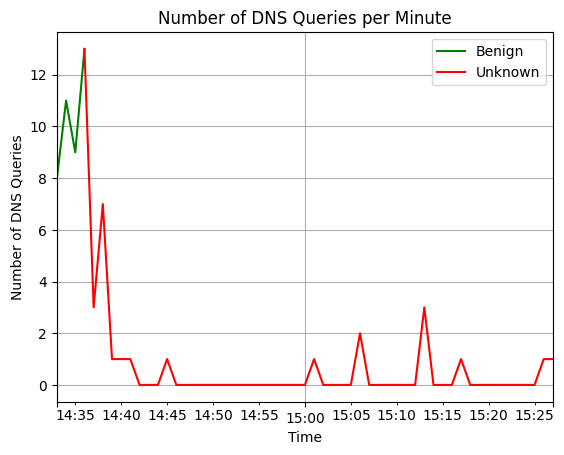

In [137]:
# Plotting DNS queries per minute
dns_per_min[:4].plot(label="Benign", color="green")
dns_per_min[3:].plot(label="Unknown", color="red")
plt.title("Number of DNS Queries per Minute")
plt.xlabel("Time")
plt.ylabel("Number of DNS Queries")
plt.legend()
plt.grid()
plt.show()

In [138]:
conns_per_min.head(10)


ts
2020-09-02 14:33:00    20
2020-09-02 14:34:00    26
2020-09-02 14:35:00    18
2020-09-02 14:36:00    34
2020-09-02 14:37:00     7
2020-09-02 14:38:00    16
2020-09-02 14:39:00     4
2020-09-02 14:40:00     2
2020-09-02 14:41:00     2
2020-09-02 14:42:00     0
Freq: min, dtype: int64

In [139]:
conns_per_min.describe()

count    64.000000
mean      3.484375
std       6.697529
min       0.000000
25%       0.000000
50%       1.000000
75%       3.000000
max      34.000000
dtype: float64

In [140]:
dns_per_min.head(10)

ts
2020-09-02 14:33:00     8
2020-09-02 14:34:00    11
2020-09-02 14:35:00     9
2020-09-02 14:36:00    13
2020-09-02 14:37:00     3
2020-09-02 14:38:00     7
2020-09-02 14:39:00     1
2020-09-02 14:40:00     1
2020-09-02 14:41:00     1
2020-09-02 14:42:00     0
Freq: min, dtype: int64

In [141]:
dns_per_min.describe()

count    55.000000
mean      1.163636
std       2.852962
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max      13.000000
dtype: float64

In [142]:
# Let's analyze the traffic after the first 4 minutes - the unknown data
start_time_unknown = start_time + pd.Timedelta(minutes=4)

# Drop the index 
# conn_df.reset_index(inplace=True)

# # Filter the dataframes to only include data after the first 4 minutes
# conn_df_unknown = conn_df[conn_df["ts"] >= start_time_unknown]
# dns_df_unknown = dns_df[dns_df["ts"] >= start_time_unknown]
# http_df_unknown = http_df[http_df["ts"] >= start_time_unknown]
# ssl_df_unknown = ssl_df[ssl_df["ts"] >= start_time_unknown]
# files_df_unknown = files_df[files_df["ts"] >= start_time_unknown]

In [144]:
conn_df["label"] = np.where(conn_df["ts"] < start_time_unknown, "benign", "unknown")
dns_df["label"] = np.where(dns_df["ts"] < start_time_unknown, "benign", "unknown")

In [146]:
conn_df.head(100)

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label
0,2020-09-02 14:33:23.796334982,CMLZbu3FDJYoZwa27k,10.8.0.117,1210,8.8.8.8,53,udp,dns,0 days 00:00:00.010542,31,...,NaN,NaN,0,Dd,1,59,1,108,NaN,benign
1,2020-09-02 14:33:48.334928036,CgRCjV3z8dKmNVIvhb,10.8.0.117,43814,8.8.8.8,53,udp,dns,0 days 00:00:00.010908,33,...,NaN,NaN,0,Dd,1,61,1,115,NaN,benign
2,2020-09-02 14:33:49.757675886,CgFfWv3PUApAZUINNf,10.8.0.117,51631,8.8.8.8,53,udp,dns,0 days 00:00:00.010734,50,...,NaN,NaN,0,Dd,1,78,1,94,NaN,benign
3,2020-09-02 14:33:49.863610983,CIkFu02IznJPZcp1El,10.8.0.117,65449,8.8.8.8,53,udp,dns,0 days 00:00:00.010405,37,...,NaN,NaN,0,Dd,1,65,1,119,NaN,benign
4,2020-09-02 14:33:51.540623903,Cylq6E2mc9lVLjs8ua,10.8.0.117,63247,8.8.8.8,53,udp,dns,0 days 00:00:00.009332,40,...,NaN,NaN,0,Dd,1,68,1,108,NaN,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2020-09-02 14:38:48.422017097,CWApfN3UTvjGLZyJKl,10.8.0.117,19962,8.8.8.8,53,udp,dns,0 days 00:00:00.011190,36,...,NaN,NaN,0,Dd,1,64,1,122,NaN,unknown
96,2020-09-02 14:38:50.206635952,CGolb645kmwKxfZxt7,10.8.0.117,13900,8.8.8.8,53,udp,dns,0 days 00:00:00.011724,33,...,NaN,NaN,0,Dd,1,61,1,115,NaN,unknown
97,2020-09-02 14:38:50.940470934,CXDHlA1iGWzdQS7LIc,10.8.0.117,27862,8.8.8.8,53,udp,dns,0 days 00:00:00.010512,37,...,NaN,NaN,0,Dd,1,65,1,119,NaN,unknown
98,2020-09-02 14:38:52.271037102,CmwWGt1PO1uaGODfjd,10.8.0.117,14443,8.8.8.8,53,udp,dns,0 days 00:00:00.016970,49,...,NaN,NaN,0,Dd,1,77,1,112,NaN,unknown


In [147]:
dns_df.head(100)

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,trans_id,rtt,query,...,rcode_name,AA,TC,RD,RA,Z,answers,TTLs,rejected,label
0,2020-09-02 14:33:23.796334982,CMLZbu3FDJYoZwa27k,10.8.0.117,1210,8.8.8.8,53,udp,15630,0 days 00:00:00.010542,portal.fb.com,...,NOERROR,F,F,T,T,0,"star.c10r.facebook.com,157.240.30.18","174.000000,59.000000",F,benign
1,2020-09-02 14:33:48.334928036,CgRCjV3z8dKmNVIvhb,10.8.0.117,43814,8.8.8.8,53,udp,35052,0 days 00:00:00.010908,i.instagram.com,...,NOERROR,F,F,T,T,0,"instagram.c10r.facebook.com,157.240.30.63","3599.000000,2.000000",F,benign
2,2020-09-02 14:33:49.757675886,CgFfWv3PUApAZUINNf,10.8.0.117,51631,8.8.8.8,53,udp,55600,0 days 00:00:00.010734,scontent-prg1-1.cdninstagram.com,...,NOERROR,F,F,T,T,0,157.240.30.63,59.000000,F,benign
3,2020-09-02 14:33:49.863610983,CIkFu02IznJPZcp1El,10.8.0.117,65449,8.8.8.8,53,udp,39507,0 days 00:00:00.010405,graph.instagram.com,...,NOERROR,F,F,T,T,0,"instagram.c10r.facebook.com,157.240.30.63","3599.000000,30.000000",F,benign
4,2020-09-02 14:33:51.540623903,Cylq6E2mc9lVLjs8ua,10.8.0.117,63247,8.8.8.8,53,udp,41491,0 days 00:00:00.009332,edge-mqtt.facebook.com,...,NOERROR,F,F,T,T,0,"mqtt.c10r.facebook.com,157.240.30.11","1236.000000,37.000000",F,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,2020-09-02 15:13:09.453067064,Cyw1E94W8FfeSPczJk,10.8.0.117,60718,8.8.8.8,53,udp,64687,0 days 00:00:00.018982,android.googleapis.com,...,NOERROR,F,F,T,T,0,216.58.201.74,299.000000,F,unknown
60,2020-09-02 15:13:39.478319883,C0jMGu1frh9ei1Wmqc,10.8.0.117,60710,8.8.8.8,53,udp,48649,0 days 00:00:00.009136,people-pa.googleapis.com,...,NOERROR,F,F,T,T,0,216.58.201.106,247.000000,F,unknown
61,2020-09-02 15:17:56.417140961,COs0MF2BvtxqwwWZBl,10.8.0.117,16281,8.8.8.8,53,udp,23329,0 days 00:00:00.009862,people-pa.googleapis.com,...,NOERROR,F,F,T,T,0,216.58.201.106,248.000000,F,unknown
62,2020-09-02 15:26:19.691025019,CovR8F24TUZtn0RYGj,10.8.0.117,1075,8.8.8.8,53,udp,36482,0 days 00:00:00.009263,global.glbtls.t.co,...,NOERROR,F,F,T,T,0,34.102.215.127,576.000000,F,unknown


In [ ]:
conn_df.groupby("label")["id.resp_h"].nunique()

label
benign     30
unknown    20
Name: id.resp_h, dtype: int64

This is suspicious as the number of unique destinations in the unknown time period is fewer. Check whether it is communicatoin with the same host.

In [152]:
dns_df.groupby("label")["query"].nunique()

label
benign     37
unknown    16
Name: query, dtype: int64

There is a significant decrease in hosts within the unknown time period. 

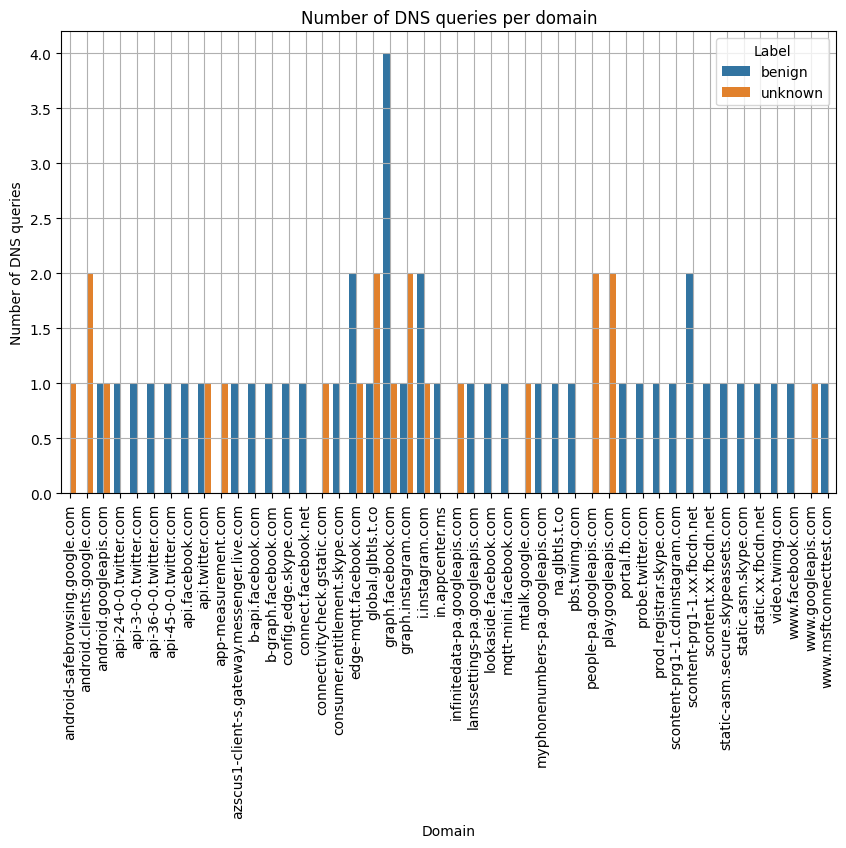

In [160]:
# Let's plot a histogram of DNS queries for each domain in the benign and unkown time period
import seaborn as sns   
dns_df["domain"] = dns_df["query"]
plt.figure(figsize=(10, 6))
sns.countplot(data=dns_df, x="domain", hue="label")
plt.title("Number of DNS queries per domain")
plt.xlabel("Domain")
plt.ylabel("Number of DNS queries")
plt.xticks(rotation=90)
plt.legend(title="Label")
plt.grid()
plt.show()

In [161]:
# Top domains searched in the unknown period
dns_df[dns_df["label"] == "unknown"]["domain"].value_counts().head(10)

domain
android.clients.google.com         2
global.glbtls.t.co                 2
graph.instagram.com                2
people-pa.googleapis.com           2
play.googleapis.com                2
android-safebrowsing.google.com    1
android.googleapis.com             1
api.twitter.com                    1
app-measurement.com                1
connectivitycheck.gstatic.com      1
Name: count, dtype: int64

In [204]:

# Top domains searched in the benign period
dns_df[dns_df["label"] == "benign"]["domain"].value_counts().head(10)

domain
graph.facebook.com              4
edge-mqtt.facebook.com          2
i.instagram.com                 2
scontent-prg1-1.xx.fbcdn.net    2
android.googleapis.com          1
api-24-0-0.twitter.com          1
api-3-0-0.twitter.com           1
api-36-0-0.twitter.com          1
api-45-0-0.twitter.com          1
api.facebook.com                1
Name: count, dtype: int64

In [165]:
# Repeated communication
top_ips = conn_df[conn_df['label']=='unknown']['id.resp_h'].value_counts().head(10)
top_ips


id.resp_h
147.32.83.230     50
8.8.8.8           21
10.8.0.117        11
69.171.250.20      6
34.102.215.127     5
157.240.30.34      4
157.240.30.63      3
172.217.23.234     3
216.58.201.106     3
74.125.71.188      3
Name: count, dtype: int64

<Axes: title={'center': 'Communication frequency with 147.32.83.230'}, xlabel='ts'>

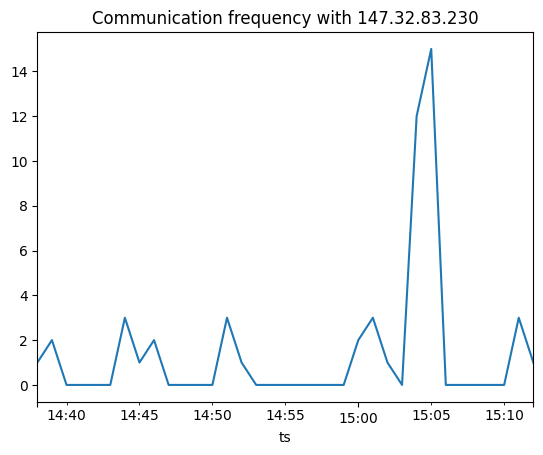

In [185]:
ip = top_ips.index[0]
conn_df[conn_df["id.resp_h"] == ip].set_index('ts').resample('1min').size().plot(
    title=f"Communication frequency with {ip}"
)


In [186]:
# bytes comparison
conn_df.groupby('label')[['orig_bytes','resp_bytes']].mean()


,orig_bytes,resp_bytes
label,,
benign,2617.049505,350174.326733
unknown,10818.674157,1029.876404


In [190]:
# Lets determine new domains in the unkown period
domains_benign = dns_df[dns_df["label"] == "benign"]["query"].unique()
domains_unknown = dns_df[dns_df["label"] == "unknown"]["query"].unique()
# the domains that are in the unknown period but not in the benign period
new_domains = set(domains_unknown) - set(domains_benign)
new_domains 

{'android-safebrowsing.google.com',
 'android.clients.google.com',
 'app-measurement.com',
 'connectivitycheck.gstatic.com',
 'infinitedata-pa.googleapis.com',
 'mtalk.google.com',
 'people-pa.googleapis.com',
 'play.googleapis.com',
 'www.googleapis.com'}

In [194]:
conn_df[conn_df["label"] == "benign"]["id.resp_p"].value_counts()

id.resp_p
443     54
53      43
4        2
80       2
1900     1
Name: count, dtype: Int64

In [196]:
conn_df[conn_df["label"] == "unknown"]["id.resp_p"].value_counts()

id.resp_p
8000     50
443      36
53       21
4         7
57736     4
5228      3
Name: count, dtype: Int64

In [198]:
# Lets see the communication taking place at rarely used ports in the unknown period - ports 5228, 57736, and 4 
rare_ports = [5228, 57736, 4]
conn_df_unknown_rare = conn_df[(conn_df["label"] == "unknown") & (conn_df["id.resp_p"].isin(rare_ports))]
conn_df_unknown_rare

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label
108,2020-09-02 14:38:52.319050074,CHTNtx4Fle9gvLfoDe,10.8.0.1,3,10.8.0.117,4,icmp,NaN,0 days 00:00:30.622713,3836,...,NaN,NaN,0,NaN,7,4032,0,0,NaN,unknown
131,2020-09-02 14:45:01.674946070,CLfWhl4LNwbNxuP75c,10.8.0.1,3,10.8.0.117,4,icmp,NaN,0 days 00:00:07.854616,1644,...,NaN,NaN,0,NaN,3,1728,0,0,NaN,unknown
133,2020-09-02 14:41:18.395142078,CE4MFJ1RAv9jD7j8f4,10.8.0.117,57736,74.125.71.188,5228,tcp,ssl,0 days 00:00:00.123012,1025,...,NaN,NaN,0,ShADad,8,1449,8,1274,NaN,unknown
141,2020-09-02 14:48:38.847400904,CLcQhW1SxpdlwFMcna,74.125.71.188,5228,10.8.0.117,57736,tcp,NaN,0 days 00:00:00.021791,24,...,NaN,NaN,0,DadA,2,128,2,132,NaN,unknown
144,2020-09-02 14:56:41.531064034,ClWzPf3oMl4uVjOMT3,10.8.0.1,3,10.8.0.117,4,icmp,NaN,0 days 00:00:00.000043,1096,...,NaN,NaN,0,NaN,2,1152,0,0,NaN,unknown
150,2020-09-02 14:57:28.858843088,Czch711A3bfMwIhkpd,10.8.0.117,57736,74.125.71.188,5228,tcp,NaN,0 days 00:00:00.063941,28,...,NaN,NaN,0,DadA,2,132,2,130,NaN,unknown
152,2020-09-02 15:02:29.594460964,CB5LlJ8vbIPKf578d,10.8.0.1,3,10.8.0.117,4,icmp,NaN,NaT,<NA>,...,NaN,NaN,0,NaN,1,576,0,0,NaN,unknown
186,2020-09-02 15:06:50.240808964,CKbPzpWdWOGdrwMaj,10.8.0.1,3,10.8.0.117,4,icmp,NaN,0 days 00:00:00.001371,3288,...,NaN,NaN,0,NaN,6,3456,0,0,NaN,unknown
195,2020-09-02 15:06:49.350353956,CDJdZD4p2nNj5M9357,74.125.71.188,5228,10.8.0.117,57736,tcp,NaN,0 days 00:00:00.022804,24,...,NaN,NaN,0,DadA,2,128,2,136,NaN,unknown
204,2020-09-02 15:13:09.500013112,CTR20RJdctfs2S6Vd,10.8.0.1,3,10.8.0.117,4,icmp,NaN,0 days 00:00:30.022600,3288,...,NaN,NaN,0,NaN,6,3456,0,0,NaN,unknown


In [199]:
# Lets see failed connections in the unknown period
failed_conns = conn_df[(conn_df["label"] == "unknown") & (conn_df["conn_state"] == "REJ")]
failed_conns

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label


In [203]:
# Lets see short sessions in the unknown period
short_sessions = conn_df[(conn_df["label"] == "unknown") & (conn_df["duration"] < pd.Timedelta(seconds=1))] 
short_sessions

,ts,uid,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,...,local_orig,local_resp,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,tunnel_parents,label
88,2020-09-02 14:37:34.019953012,CF9VVu1vAvWE78HkF1,10.8.0.117,60754,69.171.250.20,443,tcp,ssl,0 days 00:00:00.195208,2092,...,NaN,NaN,0,ShADadR,20,3140,16,1805,NaN,unknown
92,2020-09-02 14:37:34.022548914,CIus7m9I8DcRDgV03,10.8.0.117,27542,8.8.8.8,53,udp,dns,0 days 00:00:00.000852,40,...,NaN,NaN,0,Dd,1,68,1,108,NaN,unknown
93,2020-09-02 14:38:52.290865898,CizSET1Lj8XzlMpzD5,10.8.0.117,52488,216.58.201.110,443,tcp,ssl,0 days 00:00:00.274887,2893,...,NaN,NaN,0,ShADadTfF,13,4926,12,5848,NaN,unknown
95,2020-09-02 14:38:48.422017097,CWApfN3UTvjGLZyJKl,10.8.0.117,19962,8.8.8.8,53,udp,dns,0 days 00:00:00.011190,36,...,NaN,NaN,0,Dd,1,64,1,122,NaN,unknown
96,2020-09-02 14:38:50.206635952,CGolb645kmwKxfZxt7,10.8.0.117,13900,8.8.8.8,53,udp,dns,0 days 00:00:00.011724,33,...,NaN,NaN,0,Dd,1,61,1,115,NaN,unknown
97,2020-09-02 14:38:50.940470934,CXDHlA1iGWzdQS7LIc,10.8.0.117,27862,8.8.8.8,53,udp,dns,0 days 00:00:00.010512,37,...,NaN,NaN,0,Dd,1,65,1,119,NaN,unknown
98,2020-09-02 14:38:52.271037102,CmwWGt1PO1uaGODfjd,10.8.0.117,14443,8.8.8.8,53,udp,dns,0 days 00:00:00.016970,49,...,NaN,NaN,0,Dd,1,77,1,112,NaN,unknown
99,2020-09-02 14:38:52.865408897,CYEFZr4yOdql0M1oO6,10.8.0.117,25502,8.8.8.8,53,udp,dns,0 days 00:00:00.009222,47,...,NaN,NaN,0,Dd,1,75,1,91,NaN,unknown
100,2020-09-02 14:38:52.913239956,C9vurc2Yk07T7yT3G8,10.8.0.117,15204,8.8.8.8,53,udp,dns,0 days 00:00:00.028430,48,...,NaN,NaN,0,Dd,1,76,1,92,NaN,unknown
101,2020-09-02 14:38:53.745862007,CgEcRA4GoAPDj01OAf,10.8.0.117,15257,8.8.8.8,53,udp,dns,0 days 00:00:00.009246,36,...,NaN,NaN,0,Dd,1,64,1,128,NaN,unknown
